In [1]:
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import albumentations as A
import pandas as pd
import numpy as np 
import torch
import cv2
import glob

In [4]:
def generate_csv():
    source_path = r'D:/8th_Sem_Proj/Dataset/8th_Sem_Proj/' 
    file_path = source_path + r'train/Annotations_?**/*.xml'
    col = ['f_name', 'img_path', 'xmin', 'ymin', 'xmax', 'ymax', 'label']
    row = []
    for i in glob.iglob(file_path,recursive=True):
        
        xmlparse = Xet.parse(i)
        root = xmlparse.getroot()
        name = root.find('filename').text
        img_path = root.find('path').text

        for i in root.findall('object'):
            label = i.find('name').text

            for j in i.findall('bndbox'):    
                xmin = j.find('xmin').text
                ymin = j.find('ymin').text
                xmax = j.find('xmax').text
                ymax = j.find('ymax').text

                row.append({
                    'f_name' : name,
                    'img_path' : img_path,
                    'xmin' : int(xmin),
                    'ymin' : int(ymin),
                    'xmax' : int(xmax),
                    'ymax' : int(ymax),
                    'label': label
                })

    df = pd.DataFrame(row, columns=col)
    return df


In [5]:
df = generate_csv()
df

,f_name,img_path,xmin,ymin,xmax,ymax,label
0,100_46341.jpg,D:\Programs\8th_Sem_Proj\train\Tomato_Early_bl...,909,271,1738,1220,Early_Blight
1,1058_0.jpeg_itok=OQkdtxgv.jpg,D:\Programs\8th_Sem_Proj\train\Tomato_Early_bl...,4,185,797,600,Early_Blight
2,1058_0.jpeg_itok=OQkdtxgv.jpg,D:\Programs\8th_Sem_Proj\train\Tomato_Early_bl...,200,15,512,120,Early_Blight
3,126689-004-D622CD2F.jpg,D:\Programs\8th_Sem_Proj\train\Tomato_Early_bl...,10,14,541,376,Early_Blight
4,12July_mwnews_3-C.jpg,D:\Programs\8th_Sem_Proj\train\Tomato_Early_bl...,61,15,145,98,Early_Blight
...,...,...,...,...,...,...,...
743,tomato_plants_1_original.JPG_1407178095.jpg,D:\8th_Sem_Proj\Dataset\8th_Sem_Proj\train\Tom...,824,518,1273,751,mold_leaf
744,tomato_plants_1_original.JPG_1407178095.jpg,D:\8th_Sem_Proj\Dataset\8th_Sem_Proj\train\Tom...,553,756,715,910,mold_leaf
745,tomato_plants_1_original.JPG_1407178095.jpg,D:\8th_Sem_Proj\Dataset\8th_Sem_Proj\train\Tom...,921,740,1264,861,mold_leaf
746,tomato_plants_1_original.JPG_1407178095.jpg,D:\8th_Sem_Proj\Dataset\8th_Sem_Proj\train\Tom...,697,1,993,343,mold_leaf


In [7]:
df.to_csv('annotations.csv')

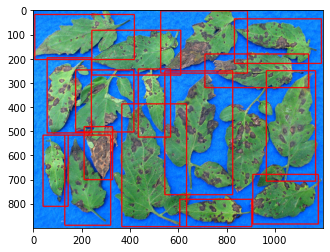

In [11]:
# Give the Source Path To The Current Folder
source_path = 'D:\8th_Sem_Proj\Dataset\8th_Sem_Proj\Dataset'

i = np.random.randint(0,len(df))
row = df.iloc[i]
name = row.f_name
img_path = row.img_path
img_path = img_path.split('8th_Sem_Proj')[-1]
img_path = source_path + img_path
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for j in range(len(df)):
    row = df.iloc[j]
    if name == row.f_name:
        cor_1 = (row.xmin, row.ymin)
        cor_2 = (row.xmax, row.ymax)
        box_color = (255, 0, 0) #RGB
        line_width = 3
        cv2.rectangle(img, cor_1, cor_2, box_color, line_width)
#cv2.imwrite(row.img_path,img)
plt.imshow(img)

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print('Data  :\t',len(df))
print('Train :\t',len(train_df))
print('Test  :\t',len(test_df))

Data  :	 748
Train :	 598
Test  :	 150


In [13]:
train_aug = A.Compose([
    A.Resize(140,140),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

test_aug = A.Compose([
    A.Resize(140,140)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [14]:
class dataset(torch.utils.data.Dataset):

    def __init__(self, df, augmentation=None):
        self.df = df
        self.augmentation = augmentation
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax

        bbox = [[xmin, ymin, xmax, ymax]]
        
        source_path = 'D:\8th_Sem_Proj\Dataset\8th_Sem_Proj\Dataset'
        img_path = row.img_path
        img_path = img_path.split('8th_Sem_Proj')[-1]
        img_path = source_path + img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentation:
            data = self.augmentation(image=img, bboxes=bbox, class_labels=[None])
            img = data['image']
            bbox = data['bboxes'][0]

         # (height, width, channel) --> (channel, height, width)
        img = torch.from_numpy(img).permute(2,0,1) / 255.0
        bbox = torch.Tensor(bbox)

        return img, bbox

In [15]:
train_set = dataset(train_df, train_aug)
test_set = dataset(test_df, test_aug)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


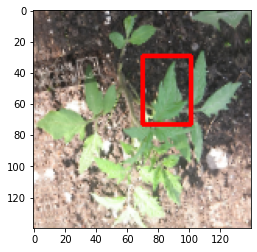

In [25]:
i = np.random.randint(0,len(train_set))
img, bbox = train_set[i]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)